# KD-tree implementation to calculate nearest postcode to supermarkets

## Import required packages/libraries

In [114]:
from scipy import spatial

import numpy as np

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

from random import shuffle
from random import randrange

import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

import datetime
import csv

%matplotlib inline

from sklearn.neighbors import KDTree 

import utm

import re

import jaydebeapi

import sqlalchemy

## Loading the Supermarket data

In [115]:
conn = jaydebeapi.connect("org.apache.hive.jdbc.HiveDriver",
                          "jdbc:hive2://egs2hstlhdpkx01.network.uk.ad:8443/;ssl=true;transportMode=HTTP;httpPath=gateway/default/hive",
                          {'password': '1990Supersissoko3', 'user': 'garciaj'},
                           "/usr/local/hive/hive-jdbc-uber-2.6.1.0-129.jar")
curs = conn.cursor()

# Making sure we get the analysis_db permissions
curs.execute("use analysis_db")

# Selecting data from a table
curs.execute("SELECT * FROM retdb_propdb_dev.data_supermarket_raw")

# Transforming that data into a pandas dataframe and saving it in res
res = pd.DataFrame(curs.fetchall())

# Changing column names. 
# NOTE: if someone can figure out how to do this automatically, without having to go 1-by-1, it would be helpful.
col_name = curs.description[0][0]
res = res.rename(columns={0:col_name})

col_name = curs.description[1][0]
res = res.rename(columns={1:col_name})

col_name = curs.description[2][0]
res = res.rename(columns={2:col_name})

col_name = curs.description[3][0]
res = res.rename(columns={3:col_name})

col_name = curs.description[4][0]
res = res.rename(columns={4:col_name})

col_name = curs.description[5][0]
res = res.rename(columns={5:col_name})

col_name = curs.description[6][0]
res = res.rename(columns={6:col_name})

col_name = curs.description[7][0]
res = res.rename(columns={7:col_name})

col_name = curs.description[8][0]
res = res.rename(columns={8:col_name})

col_name = curs.description[9][0]
res = res.rename(columns={9:col_name})

col_name = curs.description[10][0]
res = res.rename(columns={10:col_name})

col_name = curs.description[11][0]
res = res.rename(columns={11:col_name})

col_name = curs.description[12][0]
res = res.rename(columns={12:col_name})

col_name = curs.description[13][0]
res = res.rename(columns={13:col_name})

col_name = curs.description[14][0]
res = res.rename(columns={14:col_name})

col_name = curs.description[15][0]
res = res.rename(columns={15:col_name})

# Renaming columns
res.columns = [re.sub("data_supermarket_raw.","",x) for x in res.columns]

curs.close()
conn.close()
res.head()

,gluid,retailer,fascia,store_name,address_one,address_two,town,locality,postcode,long_wgs,lat_wgs,bng_e,bng_n,pqi,open_date,size_band
0,1010000001,Aldi,Aldi,Aldi Aberdeen,Unit 9-10 Boulevard Retail Park,,Aberdeen,Central Aberdeen,AB115EJ,-2.081710,57.1487,395153.81,806418.66,1,,B
1,1010000002,Aldi,Aldi,Aldi Westhill,Westhill Drive,,Westhill,,AB326FY,-2.278330,57.1549,383260.14,807138.54,1,,B
2,1010000003,Aldi,Aldi,Aldi Ellon,Ythan Terrace,,Ellon,,AB419LJ,-2.074990,57.3634,395586.81,830317.99,1,,B
3,1010000004,Aldi,Aldi,Aldi Inverurie,Loco Works Road,,Inverurie,,AB514FY,-2.378360,57.2895,377291.63,822150.23,1,,B
4,1010000005,Aldi,Aldi,Aldi Hatfield,11 Parkhouse Court,Comet Way,Hatfield,Hatfield,AL109RQ,-0.240931,51.7631,521491.85,208626.72,1,,B


#### Checking column data type

For your information, python outputs the varchar datatype as "object"

In [116]:
res.dtypes

gluid            int64
retailer        object
fascia          object
store_name      object
address_one     object
address_two     object
town            object
locality        object
postcode        object
long_wgs       float64
lat_wgs        float64
bng_e          float64
bng_n          float64
pqi             object
open_date       object
size_band       object
dtype: object

#### Cleaning dataset

* Keeping only relevant columns
* Ensuring the postcode column hasnt got any spaces

In [117]:
# Keeping only relevant columns, we don't need all to form the final dataset and for initial analysis
res = res[['retailer','bng_e','bng_n','postcode','town','size_band']]
res['postcode'] = res['postcode'].str.replace(' ','')
res.head()

,retailer,bng_e,bng_n,postcode,town,size_band
0,Aldi,395153.81,806418.66,AB115EJ,Aberdeen,B
1,Aldi,383260.14,807138.54,AB326FY,Westhill,B
2,Aldi,395586.81,830317.99,AB419LJ,Ellon,B
3,Aldi,377291.63,822150.23,AB514FY,Inverurie,B
4,Aldi,521491.85,208626.72,AL109RQ,Hatfield,B


#### Save the final dataset as a relevant dataframe name

In [118]:
supermarket_df = res

# Supermarket visualisation

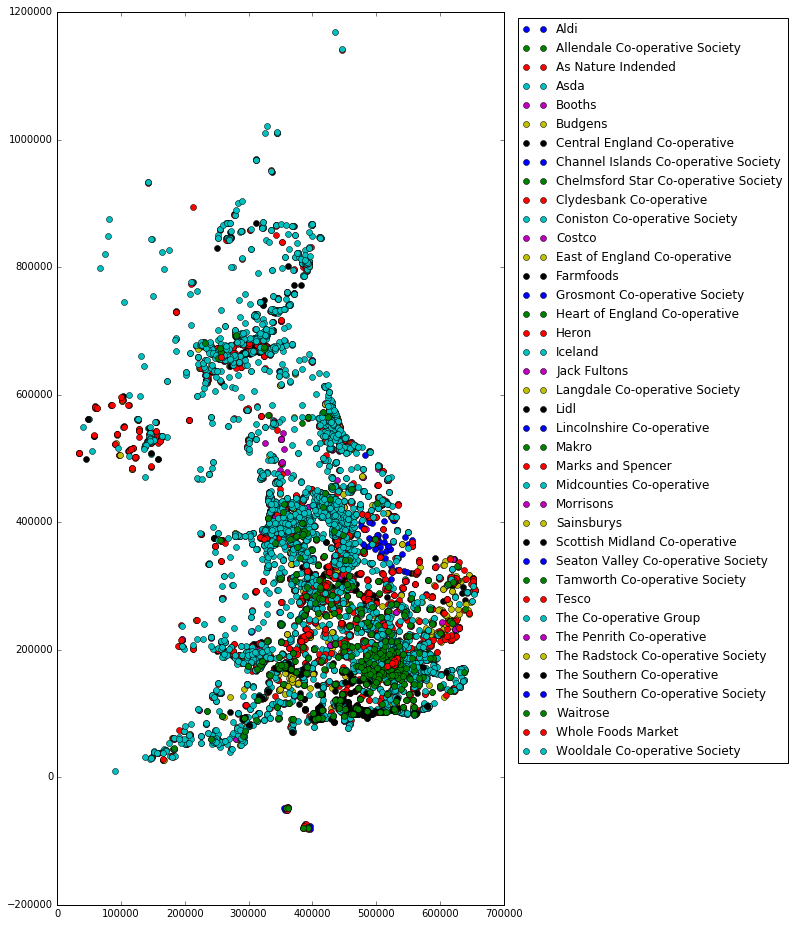

In [119]:
df_plot_raw = pd.DataFrame(dict(x = supermarket_df['bng_e'],y = supermarket_df['bng_n'], label = supermarket_df['retailer']))
groups = df_plot_raw.groupby('label')

fig = plt.figure(figsize=(8, 16))
ax = plt.subplot(111)

for name, group in groups:
    ax.plot(group.x, group.y, marker = 'o',linestyle = '', label = name)

ax.legend(bbox_to_anchor=(1.65, 1))

plt.show()

#### Are there any supermarkets that we want/dont want to analyse?

* Count the number of retail brands appearing the dataset
* Pick the ones which sound relevant in name and counts

In [120]:
my_tab = pd.crosstab(index = supermarket_df["retailer"],  # Make a crosstab
                              columns="count")      # Name the count column

my_tab

col_0,count
retailer,
Aldi,654
Allendale Co-operative Society,1
As Nature Indended,6
Asda,624
Booths,29
Budgens,206
Central England Co-operative,226
Channel Islands Co-operative Society,22
Chelmsford Star Co-operative Society,37


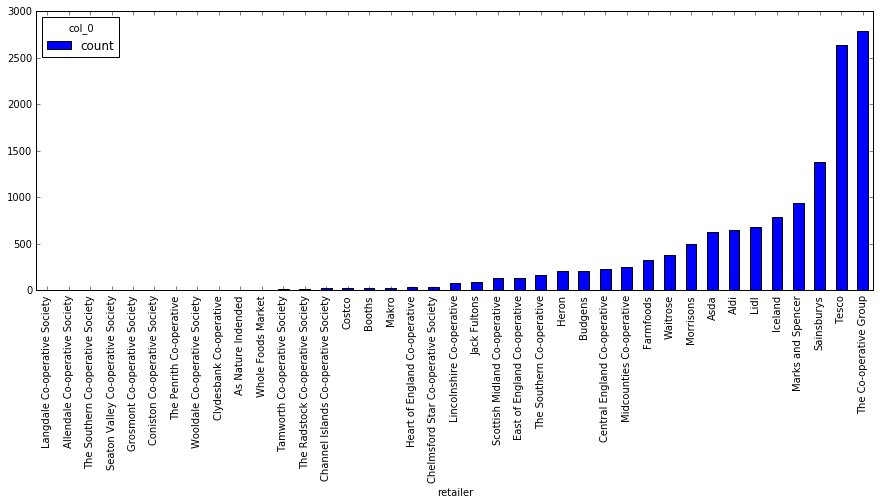

In [121]:
my_tab.sort_values("count").plot.bar(figsize=(15, 5))

In [122]:
unique_supermarkets = supermarket_df['retailer'].unique()
unique_supermarkets

array(['Aldi', 'Asda', 'Booths', 'Budgens', 'Marks and Spencer',
       'Morrisons', 'Sainsburys', 'Tesco', 'Waitrose',
       'Whole Foods Market', 'Lidl', 'Costco', 'Makro',
       'The Co-operative Group', 'The Radstock Co-operative Society',
       'Iceland', 'Allendale Co-operative Society',
       'Coniston Co-operative Society', 'Grosmont Co-operative Society',
       'Langdale Co-operative Society',
       'Seaton Valley Co-operative Society',
       'Wooldale Co-operative Society',
       'Chelmsford Star Co-operative Society',
       'Channel Islands Co-operative Society',
       'Central England Co-operative', 'Clydesbank Co-operative',
       'Tamworth Co-operative Society', 'The Penrith Co-operative',
       'The Southern Co-operative', 'Heart of England Co-operative',
       'Lincolnshire Co-operative', 'East of England Co-operative',
       'Scottish Midland Co-operative', 'Midcounties Co-operative',
       'Farmfoods', 'Heron', 'Jack Fultons', 'As Nature Indended',
    

In [123]:
supermarket_df = supermarket_df.loc[(supermarket_df['retailer'].isin(["Aldi","Asda","Booths","Budgens","Marks and Spencer"
                                                                      ,"Morrisons","Sainsburys","Tesco","Waitrose"
                                                                      ,"Whole Foods Market","Lidl","Costco","Makro","Iceland"
                                                                      ,"The Co-operative Group"]))
                                    , ]

## Loading the postcode data

In [22]:
conn = jaydebeapi.connect("org.apache.hive.jdbc.HiveDriver",
                          "jdbc:hive2://egs2hstlhdpkx01.network.uk.ad:8443/;ssl=true;transportMode=HTTP;httpPath=gateway/default/hive",
                          {'password': '1990Supersissoko3', 'user': 'garciaj'},
                           "/usr/local/hive/hive-jdbc-uber-2.6.1.0-129.jar")
curs = conn.cursor()

# Making sure we get the analysis_db permissions
curs.execute("use analysis_db")

# Selecting data from a table
curs.execute("SELECT * FROM retdb_propdb_dev.data_postcode_wt")

# Transforming that data into a pandas dataframe and saving it in res
res = pd.DataFrame(curs.fetchall())

# Changing column names. 
# NOTE: if someone can figure out how to do this automatically, without having to go 1-by-1, it would be helpful.
col_name = curs.description[0][0]
res = res.rename(columns={0:col_name})

col_name = curs.description[1][0]
res = res.rename(columns={1:col_name})

col_name = curs.description[2][0]
res = res.rename(columns={2:col_name})

col_name = curs.description[3][0]
res = res.rename(columns={3:col_name})

col_name = curs.description[4][0]
res = res.rename(columns={4:col_name})

col_name = curs.description[5][0]
res = res.rename(columns={5:col_name})

col_name = curs.description[6][0]
res = res.rename(columns={6:col_name})

col_name = curs.description[7][0]
res = res.rename(columns={7:col_name})

col_name = curs.description[8][0]
res = res.rename(columns={8:col_name})

col_name = curs.description[9][0]
res = res.rename(columns={9:col_name})

col_name = curs.description[10][0]
res = res.rename(columns={10:col_name})

col_name = curs.description[11][0]
res = res.rename(columns={11:col_name})

col_name = curs.description[12][0]
res = res.rename(columns={12:col_name})

col_name = curs.description[13][0]
res = res.rename(columns={13:col_name})

# Renaming columns
res.columns = [re.sub("data_postcode_wt.","",x) for x in res.columns]

curs.close()
conn.close()
res.head()

,postcode_raw,postcode_clean,date_introduced,easting,northing,longitude,latitude,country_code,country_name,msoa_code,msoa_name,lsoa_code,lsoa_name,last_uploaded
0,NP4 6UW,NP46UW,01-2008,326933.0,201728.0,-3.058884,51.709509,W92000004,Wales,W02000326,Torfaen 004,W01001523,Torfaen 004C,04/01/2018
1,PO8 9HG,PO89HG,01-1993,469118.0,112937.0,-1.018240,50.911771,E92000001,England,E02004710,East Hampshire 014,E01022606,East Hampshire 014A,04/01/2018
2,DA122BB,DA122BB,01-1980,565035.0,174333.0,0.373369,51.443945,E92000001,England,E02005056,Gravesham 002,E01024295,Gravesham 002E,04/01/2018
3,DA8 2NQ,DA82NQ,01-1980,552393.0,176541.0,0.192557,51.467323,E92000001,England,E02000072,Bexley 008,E01000434,Bexley 008G,04/01/2018
4,ML3 7AW,ML37AW,01-1980,272538.0,655456.0,-4.033620,55.775580,S92000003,Scotland,S02002384,None,S01012717,None,04/01/2018


#### Checking null values in key columns

* Remove records if there are null values

In [40]:
res['northing'].isnull().values.any()

True

In [41]:
res['easting'].isnull().values.any()

True

In [42]:
print(res.shape)
res = res[np.isfinite(res['northing'])]
res = res[np.isfinite(res['easting'])]
print(res.shape)

(1758312, 14)
(1745942, 14)


#### Checking column data type

For your information, python outputs the varchar datatype as "object"

In [23]:
res.dtypes

postcode_raw        object
postcode_clean      object
date_introduced     object
easting            float64
northing           float64
longitude          float64
latitude           float64
country_code        object
country_name        object
msoa_code           object
msoa_name           object
lsoa_code           object
lsoa_name           object
last_uploaded       object
dtype: object

#### Save the final dataset as a relevant dataframe name

In [43]:
postcode_df = res

## Postcode Visualisation

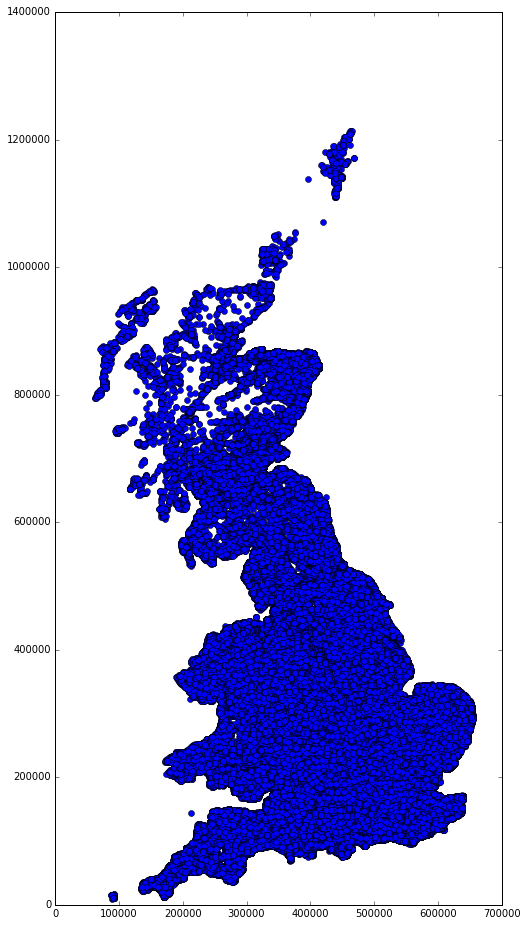

In [44]:
fig = plt.figure(figsize=(8, 16))
ax = plt.subplot(111)
ax.plot(postcode_df['easting'],postcode_df['northing'], marker = 'o', linestyle = '')

# Nearest Neighbour Methodology - KD-Trees

- Why are KD Trees much more effective than brute force nearest neighbour when dealing with high number of records or dimensions?
- Imagine we have 1 million points:
    - Brute force will calculate, for a single point, the distances to each and every 999,999 rest of the points. It will then have all distances stored and it can retrieve the minimum distance and to which point is it assigned to.
    - KD Trees uses the same distance metric (euclidean distance) but it doesn't run the formula against each and every point.
    - KD trees will pick all the x,y values and create a type of grid creating "sections" in the space (in this case a 2D space). These partitions can be represented as a decision tree / index tree.
        - If a point has an x < value of x for first split, then KD tree will not calculate distances between the analysed point and the points lying with an x value > that the value of x for the first split.
        - This means, that the number of calculations decreases dramatically.

## The process is as follows

- We are going to loop through each of the supermarkets in the desired list above.
- For each one of them, we will calculate the distance of each postcode to each one of these supermarkets.
- To do this we will:
    - I. Create a spatial index for the subset of the supermarkets
    - II. Calculate distances for each postcode
    - III. Append that distance as a new column called X (being X the name of the supermarket)

In [124]:
search_dataset = postcode_df
indexed_dataset = supermarket_df

In [125]:
unique_supermarkets = supermarket_df['retailer'].unique()
unique_supermarkets

array(['Aldi', 'Asda', 'Booths', 'Budgens', 'Marks and Spencer',
       'Morrisons', 'Sainsburys', 'Tesco', 'Waitrose',
       'Whole Foods Market', 'Lidl', 'Costco', 'Makro',
       'The Co-operative Group', 'Iceland'], dtype=object)

#### Create a spatial index for each supermarket and calculate distances

In [126]:
start_time_2 = datetime.datetime.now()

for i in unique_supermarkets:
    print(i)
    print('----------------------------------------------')
    
    start_time_1 = datetime.datetime.now()
    
    # We subset the data for a specific supermarket
    data_for_index = indexed_dataset.loc[(indexed_dataset['retailer'] == i)]
    
    start_time = datetime.datetime.now()
    kd_tree = KDTree(data_for_index[['bng_e','bng_n']], leaf_size = 2, metric = "euclidean")
    end_time = datetime.datetime.now()

    print('KD tree built for spatial index built. Time taken: ', end_time - start_time)
    print('')

    # Create variable to add a column of distance to supermarket [i]
    column_name = 'Distance_to_' + i
            
    # Calculate distances for a particular point. k = 1, as we only want the first nearest neighbour.
    dist, ind = kd_tree.query(search_dataset[['easting','northing']], k = 1)   

    print(len(dist))
    print('')

    search_dataset[column_name] = dist
        
    end_time_1 = datetime.datetime.now()            
        
    print('Nearest distances calculated. Time taken: ', end_time_1 - start_time_1)
    print('')
    
end_time_2 = datetime.datetime.now()            
print('-------------------------------------------------------------------------------------------')
print('Nearest distances calculated for all supermarkets. Time taken: ', end_time_2 - start_time_2)
print('-------------------------------------------------------------------------------------------')
print('')

print(search_dataset[0:3])    
    

Aldi
----------------------------------------------
KD tree built for spatial index built. Time taken:  0:00:00.001202

1745942

Nearest distances calculated. Time taken:  0:00:01.312278

Asda
----------------------------------------------
KD tree built for spatial index built. Time taken:  0:00:00.002164

1745942

Nearest distances calculated. Time taken:  0:00:01.401115

Booths
----------------------------------------------
KD tree built for spatial index built. Time taken:  0:00:00.000945

1745942

Nearest distances calculated. Time taken:  0:00:00.493845

Budgens
----------------------------------------------
KD tree built for spatial index built. Time taken:  0:00:00.000919

1745942

Nearest distances calculated. Time taken:  0:00:01.078191

Marks and Spencer
----------------------------------------------
KD tree built for spatial index built. Time taken:  0:00:00.001215

1745942

Nearest distances calculated. Time taken:  0:00:01.267021

Morrisons
--------------------------------

# Final dataset to send to Hive

In [127]:
search_dataset.columns = [re.sub(" ","_",x) for x in search_dataset.columns]

In [128]:
search_dataset.head()

,postcode_raw,postcode_clean,date_introduced,easting,northing,longitude,latitude,country_code,country_name,msoa_code,...,Distance_to_Costco,Distance_to_Makro,Distance_to_TheCo-operativeGroup,Distance_to_Iceland,Distance_to_Marks_and_Spencer,Distance_to_Whole_Foods_Market,Distance_to_The_Co-operative_Group,Distance_to_Marks_and_Spencer,Distance_to_Whole_Foods_Market,Distance_to_The_Co-operative_Group
0,NP4 6UW,NP46UW,01-2008,326933.0,201728.0,-3.058884,51.709509,W92000004,Wales,W02000326,...,28447.298463,22065.506004,3023.787360,1314.266416,6820.573537,69743.813966,3023.787360,6820.573537,69743.813966,3023.787360
1,PO8 9HG,PO89HG,01-1993,469118.0,112937.0,-1.018240,50.911771,E92000001,England,E02004710,...,29648.118576,17332.890203,8305.290989,3668.112957,3481.519225,78903.274103,8305.290989,3481.519225,78903.274103,8305.290989
2,DA122BB,DA122BB,01-1980,565035.0,174333.0,0.373369,51.443945,E92000001,England,E02005056,...,7745.641798,23329.163070,1808.656131,664.217386,3647.520644,33821.016116,1808.656131,3647.520644,33821.016116,1808.656131
3,DA8 2NQ,DA82NQ,01-1980,552393.0,176541.0,0.192557,51.467323,E92000001,England,E02000072,...,6412.705774,11579.620571,2613.019135,1680.130743,2701.475055,21386.010408,2613.019135,2701.475055,21386.010408,2613.019135
4,ML3 7AW,ML37AW,01-1980,272538.0,655456.0,-4.033620,55.775580,S92000003,Scotland,S02002384,...,16464.325056,22899.696145,1656.221302,339.313704,196.949051,16726.230150,1656.221302,196.949051,16726.230150,1656.221302


In [129]:
search_dataset.columns

Index(['postcode_raw', 'postcode_clean', 'date_introduced', 'easting',
       'northing', 'longitude', 'latitude', 'country_code', 'country_name',
       'msoa_code', 'msoa_name', 'lsoa_code', 'lsoa_name', 'last_uploaded',
       'Distance_to_Aldi', 'Distance_to_Asda', 'Distance_to_Booths',
       'Distance_to_Budgens', 'Distance_to_MarksandSpencer',
       'Distance_to_Morrisons', 'Distance_to_Sainsburys', 'Distance_to_Tesco',
       'Distance_to_Waitrose', 'Distance_to_WholeFoodsMarket',
       'Distance_to_Lidl', 'Distance_to_Costco', 'Distance_to_Makro',
       'Distance_to_TheCo-operativeGroup', 'Distance_to_Iceland',
       'Distance_to_Marks_and_Spencer', 'Distance_to_Whole_Foods_Market',
       'Distance_to_The_Co-operative_Group', 'Distance_to_Marks_and_Spencer',
       'Distance_to_Whole_Foods_Market', 'Distance_to_The_Co-operative_Group'],
      dtype='object')

In [130]:
upload_dataset = search_dataset[['postcode_raw'
                                , 'postcode_clean'
                                , 'Distance_to_Aldi'
                                , 'Distance_to_Asda'
                                , 'Distance_to_Booths'
                                , 'Distance_to_Budgens'
                                , 'Distance_to_Marks_and_Spencer'
                                , 'Distance_to_Morrisons'
                                , 'Distance_to_Sainsburys'
                                , 'Distance_to_Tesco'
                                , 'Distance_to_Waitrose'
                                , 'Distance_to_Whole_Foods_Market'
                                , 'Distance_to_Lidl'
                                , 'Distance_to_Costco'
                                , 'Distance_to_Makro'
                                , 'Distance_to_The_Co-operative_Group'
                                , 'Distance_to_Iceland'
                                ]]

# Writing data back to Hive

I have to figure this out

# Saving the dataset

In [131]:
upload_dataset.to_csv("/home/garciaj/LOOKUP/knn_supermarkets/postcode_nn_supermarket.csv")